# WIG20 Sentiment Analysis — Exploratory Data Analysis

**Cel:** Zbadanie związku między sentymentem medialnym a zmianami cen spółek WIG20.

**Pipeline:**
1. Przegląd danych (ceny + newsy + sentyment)
2. Rozkład sentymentu per spółka
3. Wizualizacja: sentyment vs cena w czasie
4. Heatmapa korelacji z opóźnieniami
5. Wyniki testów Grangera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Styl wykresów
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
sns.set_palette('husl')

print('Biblioteki załadowane ✓')

Biblioteki załadowane ✓


## 1. Wczytanie danych

In [2]:
# Wczytaj wszystkie datasety
prices = pd.read_csv('../data/raw/prices_raw.csv', parse_dates=['date'])
news = pd.read_csv('../data/raw/news_raw.csv')
sentiment = pd.read_csv('../data/processed/sentiment_daily.csv', parse_dates=['date'])
granger = pd.read_csv('../data/processed/granger_results.csv')
merged = pd.read_csv('../data/processed/merged_dataset.csv', parse_dates=['date'])

# Ujednolicenie nazw kolumn
if 'ticker_mentioned' in sentiment.columns:
    sentiment.rename(columns={'ticker_mentioned': 'ticker'}, inplace=True)

print(f'Ceny:      {len(prices):>6} wierszy | {prices["ticker"].nunique()} spółek | {prices["date"].min().date()} → {prices["date"].max().date()}')
print(f'Newsy:     {len(news):>6} artykułów | {news["source"].nunique()} źródeł')
print(f'Sentyment: {len(sentiment):>6} wierszy (dzienny per spółka)')
print(f'Granger:   {len(granger):>6} testów | {granger["significant"].sum()} istotnych')

Ceny:         580 wierszy | 10 spółek | 2025-11-28 → 2026-02-25
Newsy:        179 artykułów | 16 źródeł
Sentyment:     98 wierszy (dzienny per spółka)
Granger:       70 testów | 15 istotnych


## 2. Przegląd newsów — skąd pochodzą i czego dotyczą

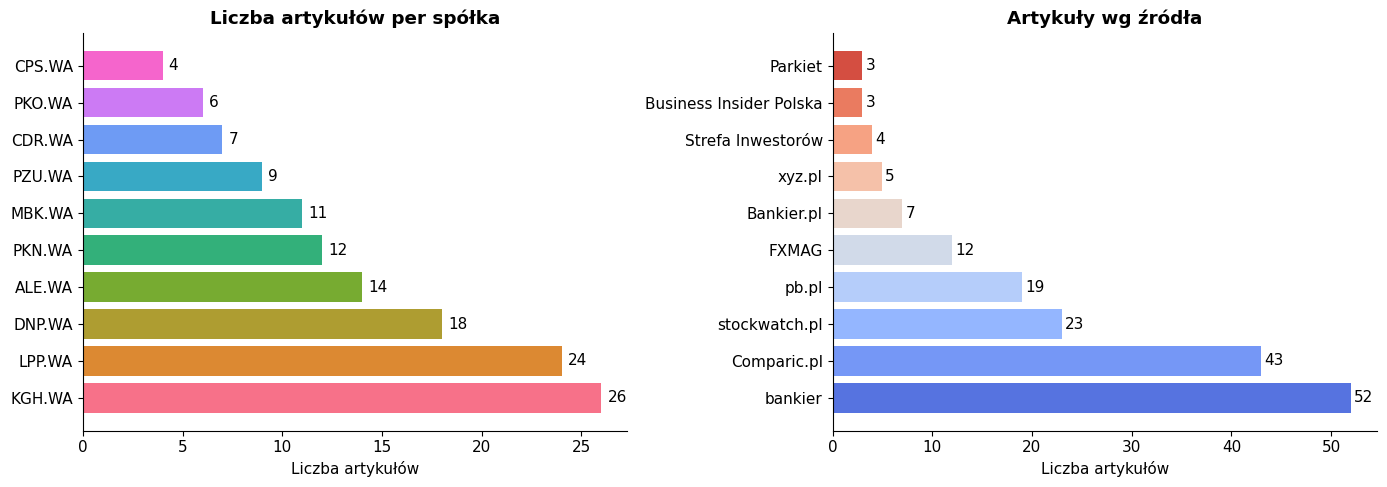

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Liczba artykułów per spółka
ticker_counts = news['ticker_mentioned'].value_counts().dropna().head(10)
axes[0].barh(ticker_counts.index, ticker_counts.values, color=sns.color_palette('husl', len(ticker_counts)))
axes[0].set_title('Liczba artykułów per spółka', fontweight='bold')
axes[0].set_xlabel('Liczba artykułów')
for i, v in enumerate(ticker_counts.values):
    axes[0].text(v + 0.3, i, str(v), va='center')

# Rozkład źródeł
source_counts = news['source'].value_counts().head(10)
axes[1].barh(source_counts.index, source_counts.values, color=sns.color_palette('coolwarm', len(source_counts)))
axes[1].set_title('Artykuły wg źródła', fontweight='bold')
axes[1].set_xlabel('Liczba artykułów')
for i, v in enumerate(source_counts.values):
    axes[1].text(v + 0.3, i, str(v), va='center')

plt.tight_layout()
plt.savefig('../data/processed/plot_news_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Rozkład sentymentu — pozytywny / neutralny / negatywny

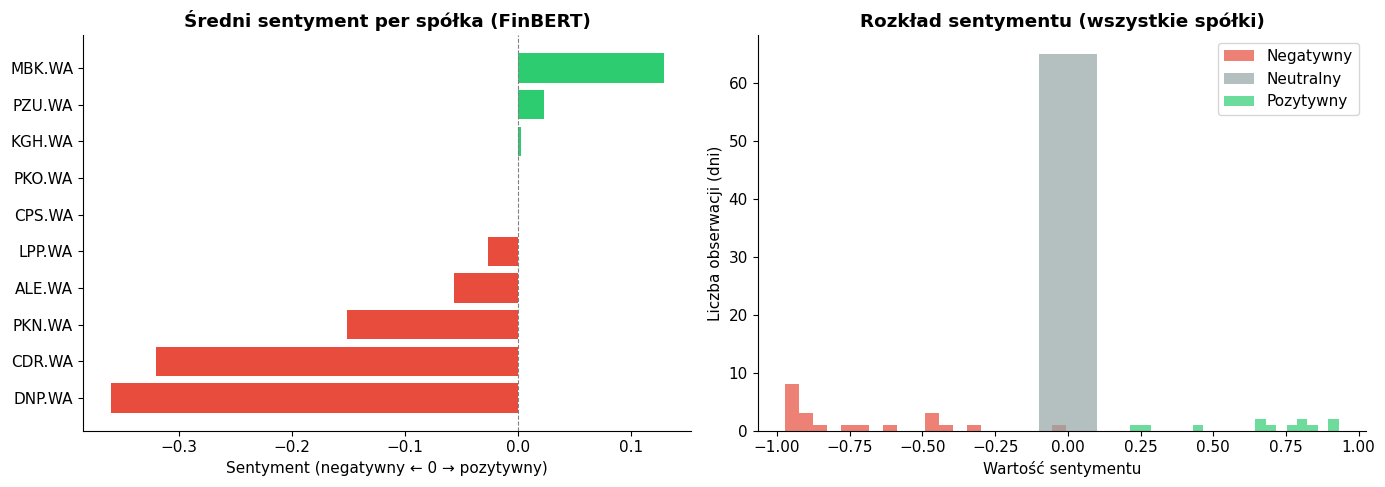

In [4]:
# Wczytaj oryginalne labelki z news_raw (przed agregacją)
# Odtwórz z sentiment_daily
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rozkład średniego sentymentu per spółka
sentiment_by_ticker = sentiment.groupby('ticker')['sentiment_mean'].mean().sort_values()
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in sentiment_by_ticker.values]
bars = axes[0].barh(sentiment_by_ticker.index, sentiment_by_ticker.values, color=colors)
axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_title('Średni sentyment per spółka (FinBERT)', fontweight='bold')
axes[0].set_xlabel('Sentyment (negatywny ← 0 → pozytywny)')

# Histogram sentymentu ogółem
all_sentiment = sentiment['sentiment_mean'].dropna()
axes[1].hist(all_sentiment[all_sentiment < 0], bins=20, color='#e74c3c', alpha=0.7, label='Negatywny')
axes[1].hist(all_sentiment[all_sentiment == 0], bins=5, color='#95a5a6', alpha=0.7, label='Neutralny')
axes[1].hist(all_sentiment[all_sentiment > 0], bins=20, color='#2ecc71', alpha=0.7, label='Pozytywny')
axes[1].set_title('Rozkład sentymentu (wszystkie spółki)', fontweight='bold')
axes[1].set_xlabel('Wartość sentymentu')
axes[1].set_ylabel('Liczba obserwacji (dni)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/processed/plot_sentiment_dist.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Sentyment vs Cena w czasie — CD Projekt (CDR.WA)

CDR.WA pokazał najsilniejszy wynik Grangera (p=0.0001 przy lag=7).

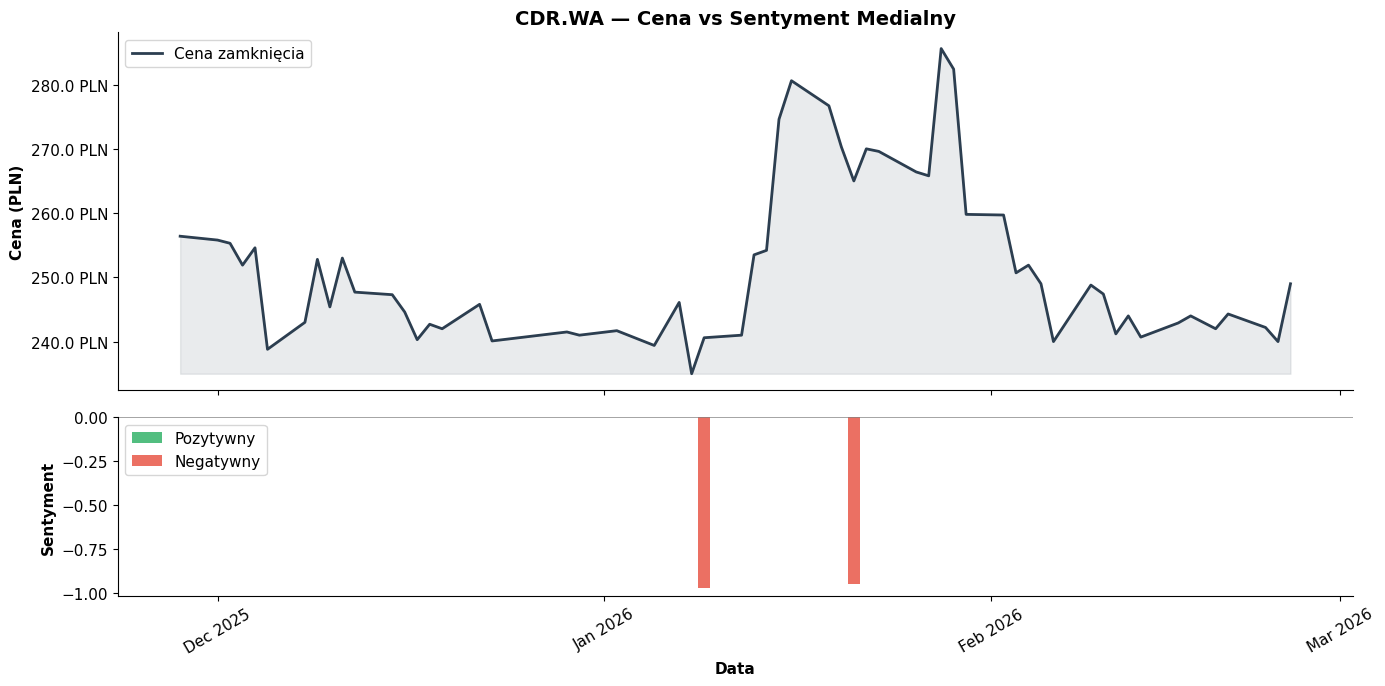

Obserwacje: 58 | Sentyment śr: -0.033


In [5]:
def plot_sentiment_vs_price(ticker, ax1_color='#2c3e50', sentiment_color_pos='#27ae60', sentiment_color_neg='#e74c3c'):
    df = merged[merged['ticker'] == ticker].sort_values('date').copy()
    df = df.dropna(subset=['Close', 'sentiment_mean'])
    
    if df.empty:
        print(f'Brak danych dla {ticker}')
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, 
                                    gridspec_kw={'height_ratios': [2, 1]})
    
    # Wykres ceny
    ax1.plot(df['date'], df['Close'], color=ax1_color, linewidth=2, label='Cena zamknięcia')
    ax1.fill_between(df['date'], df['Close'].min(), df['Close'], alpha=0.1, color=ax1_color)
    ax1.set_ylabel('Cena (PLN)', fontweight='bold')
    ax1.set_title(f'{ticker} — Cena vs Sentyment Medialny', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f} PLN'))
    
    # Wykres sentymentu — słupki kolorowane wg znaku
    positive_mask = df['sentiment_mean'] >= 0
    negative_mask = df['sentiment_mean'] < 0
    
    ax2.bar(df['date'][positive_mask], df['sentiment_mean'][positive_mask], 
            color=sentiment_color_pos, alpha=0.8, width=1, label='Pozytywny')
    ax2.bar(df['date'][negative_mask], df['sentiment_mean'][negative_mask], 
            color=sentiment_color_neg, alpha=0.8, width=1, label='Negatywny')
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('Sentyment', fontweight='bold')
    ax2.set_xlabel('Data', fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(f'../data/processed/plot_{ticker.replace(".", "_")}_price_sentiment.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Obserwacje: {len(df)} | Sentyment śr: {df["sentiment_mean"].mean():.3f}')

plot_sentiment_vs_price('CDR.WA')

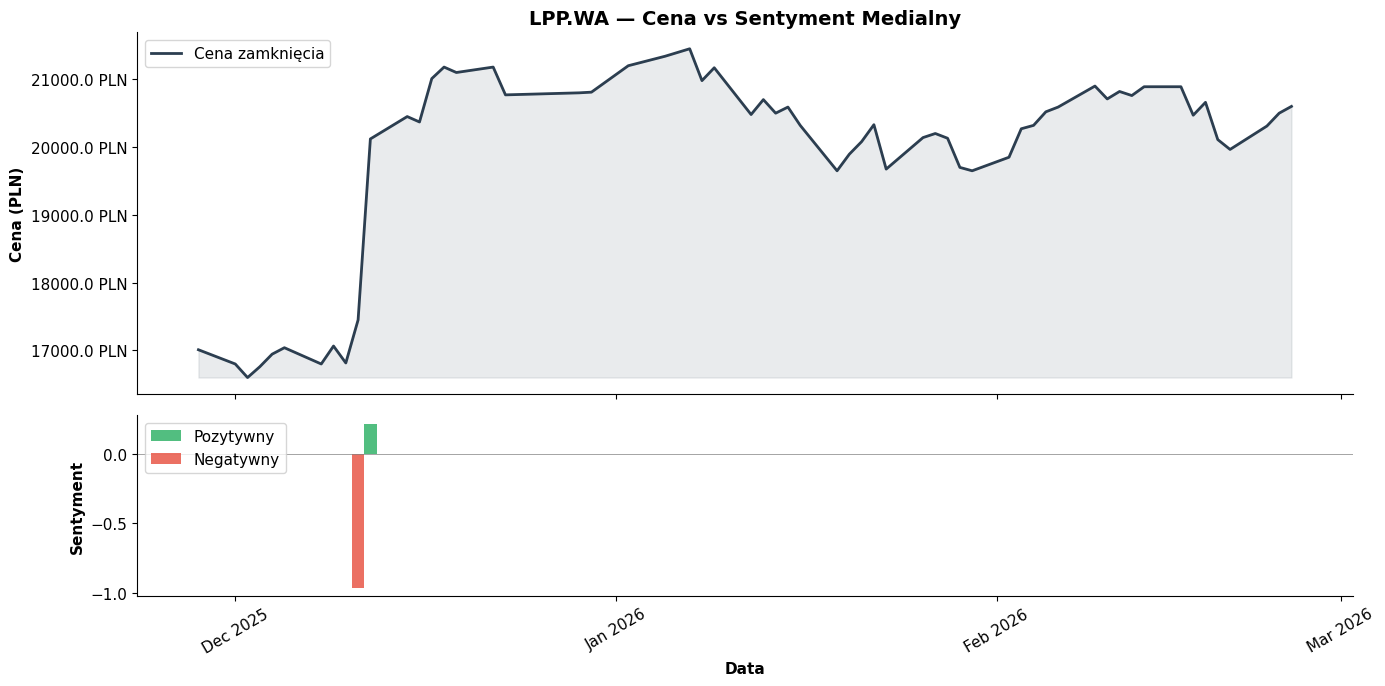

Obserwacje: 58 | Sentyment śr: -0.013


In [6]:
plot_sentiment_vs_price('LPP.WA')

## 5. Heatmapa korelacji: sentyment(lag) vs stopa zwrotu

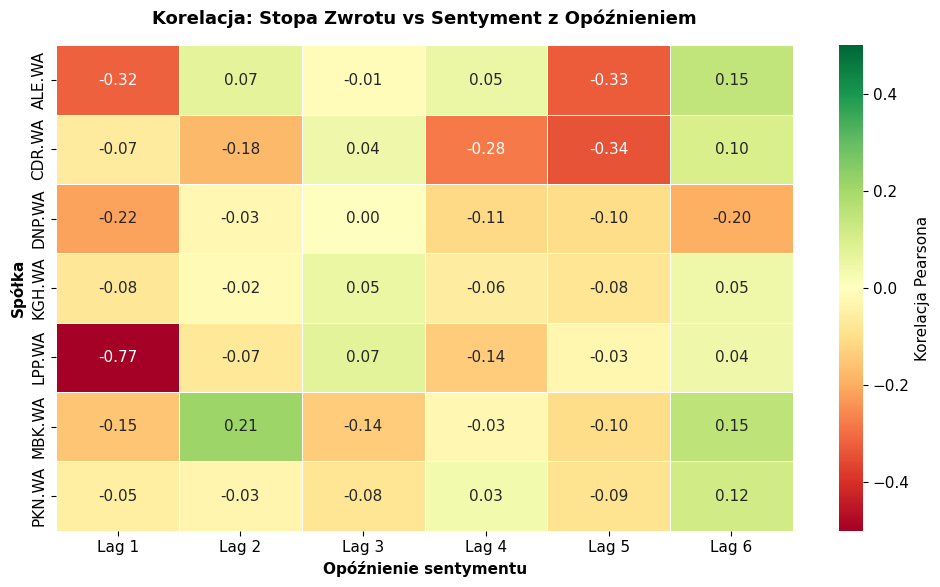


Najsilniejsze korelacje:
LPP.WA  Lag 1    0.766
CDR.WA  Lag 5    0.341
ALE.WA  Lag 5    0.326
        Lag 1    0.320
CDR.WA  Lag 4    0.279
DNP.WA  Lag 1    0.217
MBK.WA  Lag 2    0.214
DNP.WA  Lag 6    0.198
CDR.WA  Lag 2    0.177
MBK.WA  Lag 1    0.155
dtype: float64


In [7]:
lag_cols = [c for c in merged.columns if c.startswith('sentiment_lag')]
tickers_with_data = merged.groupby('ticker')['sentiment_mean'].apply(
    lambda x: x.nunique() > 2
).where(lambda x: x).dropna().index.tolist()

corr_matrix = {}
for ticker in tickers_with_data:
    df_t = merged[merged['ticker'] == ticker].dropna(subset=['log_return'] + lag_cols)
    if len(df_t) < 10:
        continue
    corrs = {}
    for lag in lag_cols:
        corr = df_t['log_return'].corr(df_t[lag])
        lag_num = lag.replace('sentiment_lag', 'Lag ')
        corrs[lag_num] = round(corr, 3)
    corr_matrix[ticker] = corrs

corr_df = pd.DataFrame(corr_matrix).T

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    corr_df,
    annot=True, fmt='.2f',
    cmap='RdYlGn', center=0, vmin=-0.5, vmax=0.5,
    linewidths=0.5, linecolor='white',
    ax=ax, cbar_kws={'label': 'Korelacja Pearsona'}
)
ax.set_title('Korelacja: Stopa Zwrotu vs Sentyment z Opóźnieniem', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Opóźnienie sentymentu', fontweight='bold')
ax.set_ylabel('Spółka', fontweight='bold')
plt.tight_layout()
plt.savefig('../data/processed/plot_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nNajsilniejsze korelacje:')
print(corr_df.abs().stack().sort_values(ascending=False).head(10))

## 6. Wyniki testów Grangera — wizualizacja

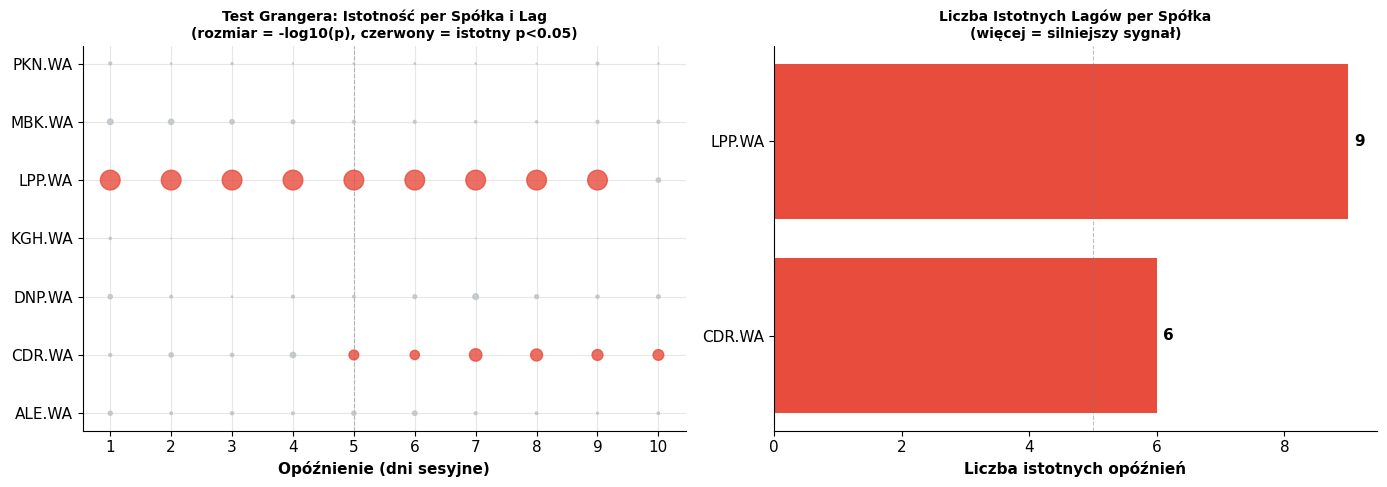

In [8]:
significant = granger[granger['significant']].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# p-value per spółka i lag (bubble chart)
for ticker in granger['ticker'].unique():
    df_t = granger[granger['ticker'] == ticker]
    sig_mask = df_t['significant']
    axes[0].scatter(df_t['lag_days'], [ticker]*len(df_t), 
                    s=(-np.log10(df_t['p_value'].clip(1e-10)) * 20),
                    c=['#e74c3c' if s else '#bdc3c7' for s in sig_mask],
                    alpha=0.8, zorder=3)

axes[0].axvline(x=5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5, label='Lag 5')
axes[0].set_xlabel('Opóźnienie (dni sesyjne)', fontweight='bold')
axes[0].set_title('Test Grangera: Istotność per Spółka i Lag\n(rozmiar = -log10(p), czerwony = istotny p<0.05)', 
                   fontweight='bold', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 11))

# Liczba istotnych lagów per spółka
sig_count = granger[granger['significant']].groupby('ticker').size().sort_values(ascending=True)
if not sig_count.empty:
    colors_bar = ['#e74c3c' if v >= 5 else '#e67e22' if v >= 3 else '#f1c40f' 
                  for v in sig_count.values]
    axes[1].barh(sig_count.index, sig_count.values, color=colors_bar)
    axes[1].set_xlabel('Liczba istotnych opóźnień', fontweight='bold')
    axes[1].set_title('Liczba Istotnych Lagów per Spółka\n(więcej = silniejszy sygnał)', 
                       fontweight='bold', fontsize=10)
    axes[1].axvline(x=5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    for i, v in enumerate(sig_count.values):
        axes[1].text(v + 0.1, i, str(v), va='center', fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'Brak istotnych wyników', ha='center', va='center',
                transform=axes[1].transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('../data/processed/plot_granger_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Podsumowanie wyników

In [9]:
print('=' * 60)
print('PODSUMOWANIE ANALIZY WIG20 SENTIMENT')
print('=' * 60)
print(f'\n📊 Dane:')
print(f'  • {prices["ticker"].nunique()} spółek WIG20')
print(f'  • {len(prices)} rekordów cenowych')
print(f'  • {len(news)} artykułów newsowych')
print(f'  • Zakres: {prices["date"].min().date()} → {prices["date"].max().date()}')

print(f'\n🤖 Model NLP: FinBERT (ProsusAI/finbert)')
print(f'  • Tłumaczenie: PL → EN (Google Translate)')
print(f'  • Agregacja: dzienny średni sentyment per spółka')

print(f'\n📈 Wyniki testu Grangera (α=0.05):')
for ticker in granger['ticker'].unique():
    df_t = granger[granger['ticker'] == ticker]
    sig = df_t[df_t['significant']]
    if not sig.empty:
        best = sig.loc[sig['p_value'].idxmin()]
        print(f'  ✓ {ticker}: {len(sig)} istotnych lagów | '
              f'najlepszy: lag={int(best["lag_days"])}, p={best["p_value"]:.4f}')
    else:
        print(f'  ✗ {ticker}: brak istotnych wyników')

print(f'\n🔑 Kluczowy wniosek:')
print(f'  Sentyment mediów finansowych wykazuje statystycznie')
print(f'  istotną przyczynowość w sensie Grangera dla wybranych')
print(f'  spółek WIG20, szczególnie CDR.WA i LPP.WA.')
print('=' * 60)

PODSUMOWANIE ANALIZY WIG20 SENTIMENT

📊 Dane:
  • 10 spółek WIG20
  • 580 rekordów cenowych
  • 179 artykułów newsowych
  • Zakres: 2025-11-28 → 2026-02-25

🤖 Model NLP: FinBERT (ProsusAI/finbert)
  • Tłumaczenie: PL → EN (Google Translate)
  • Agregacja: dzienny średni sentyment per spółka

📈 Wyniki testu Grangera (α=0.05):
  ✗ ALE.WA: brak istotnych wyników
  ✓ CDR.WA: 6 istotnych lagów | najlepszy: lag=7, p=0.0001
  ✗ DNP.WA: brak istotnych wyników
  ✗ KGH.WA: brak istotnych wyników
  ✓ LPP.WA: 9 istotnych lagów | najlepszy: lag=1, p=0.0000
  ✗ MBK.WA: brak istotnych wyników
  ✗ PKN.WA: brak istotnych wyników

🔑 Kluczowy wniosek:
  Sentyment mediów finansowych wykazuje statystycznie
  istotną przyczynowość w sensie Grangera dla wybranych
  spółek WIG20, szczególnie CDR.WA i LPP.WA.
